# RLLBC Bonus Point Assignment II Part B
<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0, released 2022-06-24</div>
For task instructions, refer to the assignment PDF.

* The parts of the code you are to implement are indicated via `# TODO` comments.
* You can use the `# Test code` cells to verify your implementation. However note that these are not the unit tests used for grading.
* Some cells create export file in the `solution/` folder. _Include whole `solution/` folder in your submission_.
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting!

In [1]:
# General imports
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from tqdm.auto import tqdm
import time
import flappy_bird_gym

# Create solution folder
Path("solution/").mkdir(exist_ok=True)

## Question B1 - Deep Q-Networks
### a) Implement Replay Buffer

In [2]:
class ReplayBuffer(object):
    def __init__(self, mem_size, state_shape):
        """Initialization of the replay buffer.
        
        The memories have the following data types:
            states: float32
            next_states: float32
            actions: int64
            rewards: float32
            is_terminal: bool

        Args:
            mem_size: Capacity of this buffer
            state_shape: Shape of state and next_state
        """
        self.mem_size = mem_size  # Capacity of the buffer
        self.mem_cntr = 0         # Number of added elements
        self.state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.next_state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
    
    def is_filled(self):
        """Check if the memory is filled."""
        return self.mem_cntr >= self.mem_size

    def add(self, state, action, reward, next_state, is_terminal):
        """Add one transition to the buffer.

        Replaces the oldest transition in memory.
        """
        # TODO
        index = self.mem_cntr%self.mem_size    
        self.state_memory[index] = state
        self.next_state_memory[index] = next_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = is_terminal
        
        self.mem_cntr += 1
            
    


    def sample_batch(self, batch_size):
        """Sample one batch from the memory."""
        # TODO
        ind = np.random.choice(self.mem_size,batch_size, replace = False)
       
        states = self.state_memory[ind]
        next_states = self.next_state_memory[ind]
        actions = self.action_memory[ind]
        rewards = self.reward_memory[ind]
        is_terminal = self.terminal_memory[ind]
        
        return states, actions, rewards, next_states, is_terminal
        return states, actions, rewards, next_states, is_terminal

In [3]:
# Test code
_buffer = ReplayBuffer(10, (5, ))
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 0
for i in range(10):  # Fill test values
    _buffer.add(np.arange(5) + i, 5 + i, 6 + i, 7 + np.arange(5) + i, (12 + i) % 2 == 0)
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 10, "Wrong mem_cntr"

_is = set()
for s, a, r, s_, t in zip(*_buffer.sample_batch(5)):
    i = s[0]
    assert 0 <= i < 10, "Wrong states"
    _is.add(i)
    np.testing.assert_array_equal(s, np.arange(5) + i, err_msg="Wrong states")
    np.testing.assert_equal(a, 5 + i, err_msg="Wrong actions")
    np.testing.assert_equal(r, 6 + i, err_msg="Wrong rewards")
    np.testing.assert_array_equal(s_, 7 + np.arange(5) + i, err_msg="Wrong next states")
    np.testing.assert_equal(t, (12 + i) % 2 == 0, err_msg="Wrong terminals")
assert len(_is) == 5, "Duplicate transitions"
"ok"

'ok'

### b) Fill replay buffer

In [4]:
env = flappy_bird_gym.make("FlappyBird-v0")

# Initialize replay buffer
buffer = ReplayBuffer(mem_size=25000, state_shape=env.observation_space.shape)

# ********************
# TODO Sample transitions from environment and add to buffer
state,is_terminal = env.reset(), False
while not(buffer.is_filled()):
    while not is_terminal:
      action = env.action_space.sample()
      next_state, reward, is_terminal,_ = env.step(action)
      buffer.add(state, action, reward, next_state, is_terminal) 
      state = next_state
    state = env.reset()
    is_terminal = False

In [5]:
# Test code
assert buffer.is_filled(), f"Buffer not filled, only {buffer.mem_cntr}/{buffer.mem_size} transitions in memory"
"ok"

'ok'

## Question B2 - Deep Q-Networks
### a) Define Q-Network

In [6]:
import torch
from torch import nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
    def __init__(self):
        super(DeepQNetwork, self).__init__()
        # TODO Create layers
        self.fc1 = nn.Linear(in_features=2, out_features=64)   
#         self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=64, out_features=2)


    def forward(self, state):
        # TODO Implement forward pass
        state = torch.as_tensor(state, dtype = torch.float32)
        state = F.relu(self.fc1(state))
#         state = F.relu(self.fc2(state))
        Q = self.out(state)
        
        return Q

In [7]:
# Test code
_test_output = DeepQNetwork()(torch.FloatTensor([[1, 2]]))
assert _test_output.shape == (1, 2), f"Expected output shape (1, 2), got {_test_output.shape}"
"ok"

'ok'

### b) $\epsilon$-Greedy

In [8]:
def epsilon_greedy(state, q_network, epsilon=0.05):
    """Perform epsilon-greedy action sampling.

    Args:
        state: numpy ndarray, current state
        q_network: torch module

    Returns:
        action: one action
    """
    # TODO Epsilon-greedy action sampling

    r = np.random.random()
    if(r <= epsilon ):
        action = np.random.choice(2)
    else:
        action = q_network.forward(state).argmax()
        action = action.item()
    return action

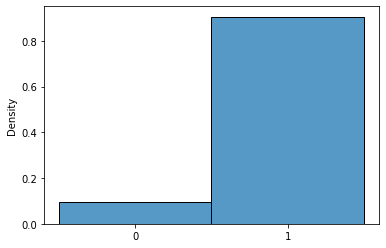

In [9]:
# Test Code
class DummyModule(nn.Module):
    def forward(self, state):
        return torch.FloatTensor([1, 2])  # Constant output


# Sample 1000 actions
_actions = [epsilon_greedy(np.array([1, 2, 3, 4]), DummyModule(), epsilon=0.2) for _ in range(1000)]

sns.histplot(_actions, discrete=True, stat="density")
plt.xticks([0, 1])
plt.show()

_zeros = 1000 - sum(_actions)
# Note: This is a stochastic test. It produces a false error in 1% of the cases
assert 75 < _zeros < 125, f"Frequency of action 0 ({_zeros}) is outside the 99% confidence interval [76, 124]"

### c) Loss Function

In [10]:
mse = nn.MSELoss()

def compute_loss(q_network, target_network, states, actions, rewards, next_states, is_terminal, gamma=0.99):
    # TODO Implement loss function
    qvals_total = q_network.forward(states)
    qvals = torch.gather(qvals_total, 1, actions)
    
    next_actions = q_network.forward(next_states).argmax(axis = 1)
    next_actions = next_actions.unsqueeze(0).reshape(-1,1)
    
    next_qvals_total = target_network.forward(next_states)
    next_qval=torch.gather(next_qvals_total, 1, next_actions).reshape(-1,1)
    
    is_terminal_int = is_terminal.long().reshape(-1,1)
    expected_qvals = rewards + gamma * (1 - is_terminal_int) * next_qval
    loss = mse(qvals, expected_qvals)

    return loss

### d) Training a new model

  0%|          | 0/100000 [00:00<?, ?it/s]

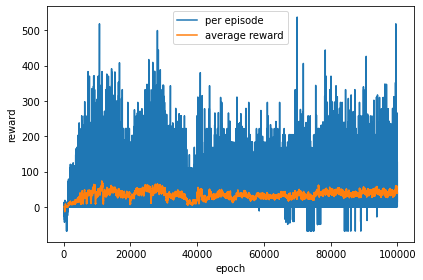

In [30]:
if not Path('solution/b2d.pt').is_file():
    print ("model exists confirm overwrite?")
    reply = input()
    if reply == "y":
    
        # Hyperparameters
        epsilon= 0.05  # For epsilon start greedy action sampling
        epsilon_min= 0.05
        epsilon_decay = 0.99
        batch_size = 64
        NETWORK_UPDATE_FREQUENCY = 4
        NETWORK_SYNC_FREQUENCY = 2000
        gamma = 0.99
        episodes = 100000
        replay_buffer_size = 0 #TODO


        q_network = DeepQNetwork()
        target_network = deepcopy(q_network)
        optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-3)
        mse = nn.MSELoss()

        step_count = 0
        total_rewards = []
        with tqdm(range(episodes)) as pbar:
            for epi in pbar:
                state, done = env.reset(), False
                rewards = []
                t=0
                if epi%100 == 0:
                    epsilon *= epsilon_decay
                    if (epsilon < epsilon_min):
                        epsilon = epsilon_min 
                while not done:
                    # Take a step
                    action = epsilon_greedy(state, q_network, epsilon=epsilon)
                    next_state, reward, done, _ = env.step(action)
                    t=t+1
                    # Bookkeeping
                    if done:
                        reward -= 100
                    rewards.append(reward)
                    buffer.add(state=state, action=action, reward=reward, next_state=next_state, is_terminal=done and t < 500)
                    state = next_state

                    step_count += 1 
                    # Update network every NETWORK_UPDATE_FREQUENCY steps
                    if step_count % NETWORK_UPDATE_FREQUENCY == 0:
                        # Sample batch of transitions
                        state_batch, action_batch, reward_batch, next_state_batch, terminal_batch = buffer.sample_batch(batch_size=batch_size)
                        state_batch = torch.FloatTensor(state_batch)
                        next_state_batch = torch.FloatTensor(next_state_batch)
                        action_batch = torch.LongTensor(action_batch).reshape(-1, 1)
                        reward_batch = torch.FloatTensor(reward_batch).reshape(-1, 1)
                        terminal_batch = torch.BoolTensor(terminal_batch)

                        # Compute loss
                        loss = compute_loss(q_network, target_network, state_batch, action_batch, reward_batch, next_state_batch, terminal_batch, gamma)

                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    # Sync networks every NETWORK_SYNC_FREQUENCY steps
                    if step_count % NETWORK_SYNC_FREQUENCY == 0:
                        # ********************
                        # TODO Synchronize networks

                        target_network.load_state_dict(q_network.state_dict())
                        target_network.eval()

                        # ********************

                total_rewards.append(sum(rewards))

                 # Print statistics
                pbar.set_description(f"Mean training reward  {np.mean(total_rewards[-100:]):.02f}")
                pbar.set_postfix({'epsilon': epsilon})
                if np.mean(total_rewards[-100:]) == 500:
                    break # Stop training

        # Save model
        with open("solution/b2d.pt", "wb") as f:
            torch.save(q_network, f)

        # Plot training
        plt.plot(total_rewards, label="per episode")
        plt.plot(pd.DataFrame(total_rewards).rolling(100).mean(), label="average reward")
        plt.xlabel("epoch")
        plt.ylabel("reward")
        plt.legend()
        plt.tight_layout()
        plt.savefig("solution/b2d.png")
    else:
        print("retrain by running next cell")

### if a saved model exists  continue training with that

model exists, retraining.....


  0%|          | 0/10000 [00:00<?, ?it/s]

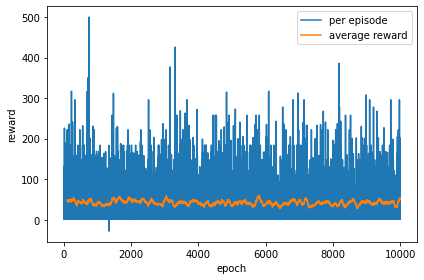

In [31]:
if not Path('solution/b2d.pt').is_file():
    print ("model does not exist")   
else:
    print ("model exists, retraining.....")
    
    # Hyperparameters 
    epsilon= 0.05  # For epsilon start greedy action sampling
    epsilon_min= 0.05
    epsilon_decay = 0.99
    batch_size = 64
    NETWORK_UPDATE_FREQUENCY = 4
    NETWORK_SYNC_FREQUENCY = 2000
    gamma = 0.99
    episodes = 10000
    replay_buffer_size = 0 #TODO


    q_network = torch.load("solution/b2d.pt")
    target_network = deepcopy(q_network)
    optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-3)
    mse = nn.MSELoss()

    step_count = 0
    total_rewards = []
    with tqdm(range(episodes)) as pbar:
        for epi in pbar:
            state, done = env.reset(), False
            rewards = []
            t=0
            if epi%100 == 0:
                epsilon *= epsilon_decay
                if (epsilon < epsilon_min):
                    epsilon = epsilon_min 
            while not done:
                # Take a step
                action = epsilon_greedy(state, q_network, epsilon=epsilon)
                next_state, reward, done, _ = env.step(action)
                t=t+1
                # Bookkeeping
                if done:
                    reward -= 100
                rewards.append(reward)
                buffer.add(state=state, action=action, reward=reward, next_state=next_state, is_terminal=done and t < 500)
                state = next_state

                step_count += 1 
                # Update network every NETWORK_UPDATE_FREQUENCY steps
                if step_count % NETWORK_UPDATE_FREQUENCY == 0:
                    # Sample batch of transitions
                    state_batch, action_batch, reward_batch, next_state_batch, terminal_batch = buffer.sample_batch(batch_size=batch_size)
                    state_batch = torch.FloatTensor(state_batch)
                    next_state_batch = torch.FloatTensor(next_state_batch)
                    action_batch = torch.LongTensor(action_batch).reshape(-1, 1)
                    reward_batch = torch.FloatTensor(reward_batch).reshape(-1, 1)
                    terminal_batch = torch.BoolTensor(terminal_batch)

                    # Compute loss
                    loss = compute_loss(q_network, target_network, state_batch, action_batch, reward_batch, next_state_batch, terminal_batch, gamma)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # Sync networks every NETWORK_SYNC_FREQUENCY steps
                if step_count % NETWORK_SYNC_FREQUENCY == 0:
                    # ********************
                    # TODO Synchronize networks

                    target_network.load_state_dict(q_network.state_dict())
                    target_network.eval()

                    # ********************

            total_rewards.append(sum(rewards))

             # Print statistics
            pbar.set_description(f"Mean training reward  {np.mean(total_rewards[-100:]):.02f}")
            pbar.set_postfix({'epsilon': epsilon})
            if np.mean(total_rewards[-100:]) == 500:
                break # Stop training

    # Save model
    with open("solution/b2d.pt", "wb") as f:
        torch.save(q_network, f)

    # Plot training
    plt.plot(total_rewards, label="per episode")
    plt.plot(pd.DataFrame(total_rewards).rolling(100).mean(), label="average reward")
    plt.xlabel("epoch")
    plt.ylabel("reward")
    plt.legend()
    plt.tight_layout()
    plt.savefig("solution/b2d.png")

In [32]:
# Test code
policy = q_network
policy.eval()  # Switch to evaluation mode


def _rollout(seed):
    env.reset()
    state, done = env.reset(), False
    t=0
    while not done:
        t=t+1
        probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
        action = np.argmax(probs.detach().numpy())  # Greedy action
        state, reward, done, _ = env.step(action)
    return t


_avg_reward = np.mean([_rollout(seed=i) for i in tqdm(range(100), desc="Validating")])
assert _avg_reward >= 487.5, f"Average reward below 487.5, got {_avg_reward}"
f"ok (Average reward {_avg_reward:0.2f})"

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

'ok (Average reward 574.36)'

In [35]:
# Take a look at the learned policy (this will not run on the JupyterHub)
env_name = "FlappyBird-v0"
# creating environment
env= flappy_bird_gym.make("FlappyBird-v0")
for i in range(10):
    env.seed(i)
    state, done = env.reset(), False
    while not done:
        probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
        action = np.argmax(probs.detach().numpy())  # Greedy action
        state, reward, done, _ = env.step(action)
        env.render()
        time.sleep(1 / 30)  # FPS

env.close()